# **질병변수만 사용**

## XGBoost

#### scale_pos_weight 사용
모델 정확도: 0.9288
<br>ROC-AUC: 0.6458
<br>F1 Score: 0.9631

데이터 v1, XGBoost 모델 정확도: 0.9288
ROC-AUC: 0.6458
F1 Score: 0.9631


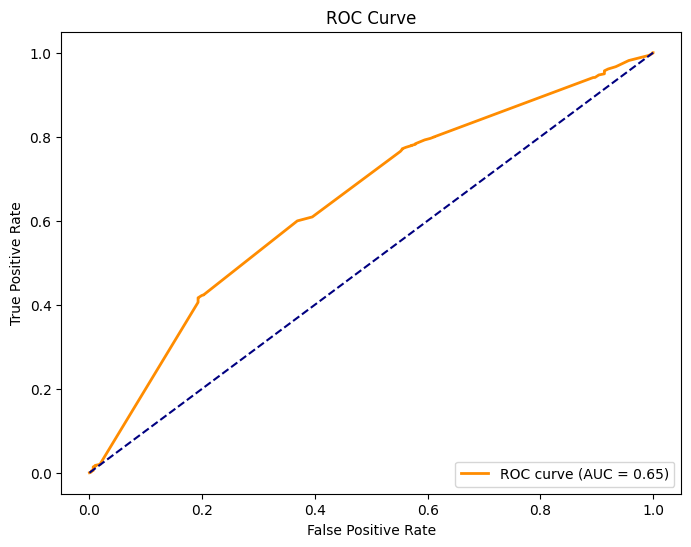

In [26]:
# with scale_pos_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 학습 with scale_pos_weight
scale_pos_weight = len(y_train) / sum(y_train)  # Negative to positive class ratio
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


#### 

## Logistic Regression

#### class_weight='balanced' 사용
모델 정확도: 0.7272
<br>ROC-AUC: 0.6494
<br>F1 Score: 0.8355

Regression Equation: y = 0.7307 + (-0.0015) * infectious_disease + (-0.4297) * renal_system + (-0.6521) * circulatory_system + (0.1673) * hematologic_lymphatic + (-0.6803) * respiratory_system + (-0.1327) * coagulation + (0.0860) * immune_system
R^2 (Determination Coefficient): -2.5064


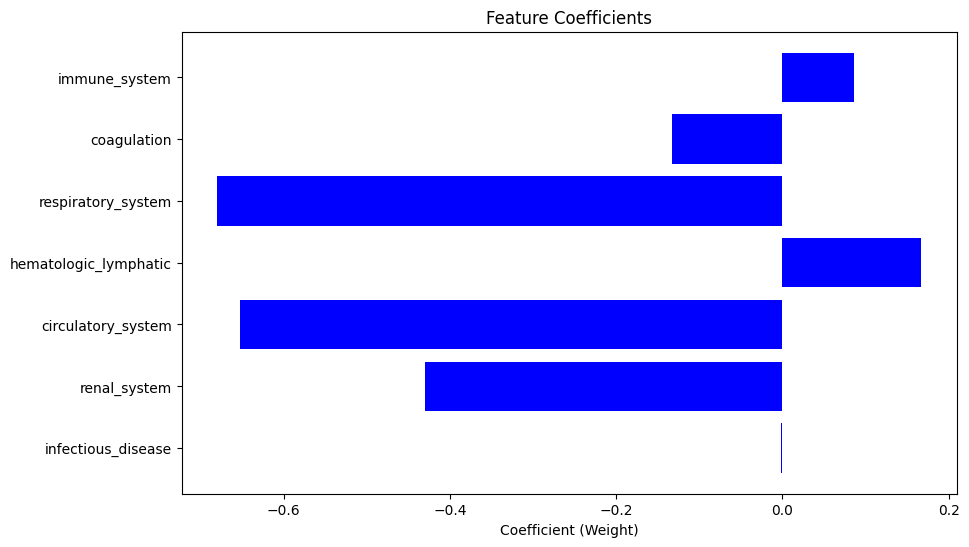

데이터 v1, logistic regression 모델 정확도: 0.7272
ROC-AUC: 0.6494
F1 Score: 0.8355


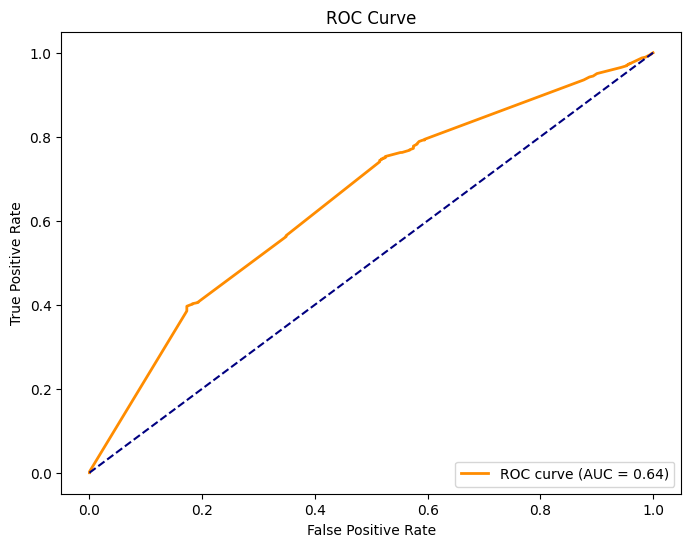

In [16]:
# class_weight='balanced'

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train, y_train)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v1, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


#### 

## Random Forest

### SMOTE 말고 class_weight='balanced' 사용
모델 정확도: 0.7561
<br> ROC-AUC: 0.6426
<br> F1 Score: 0.8561

데이터 v1, Random Forest 모델 정확도: 0.7561
ROC-AUC: 0.6426
F1 Score: 0.8561


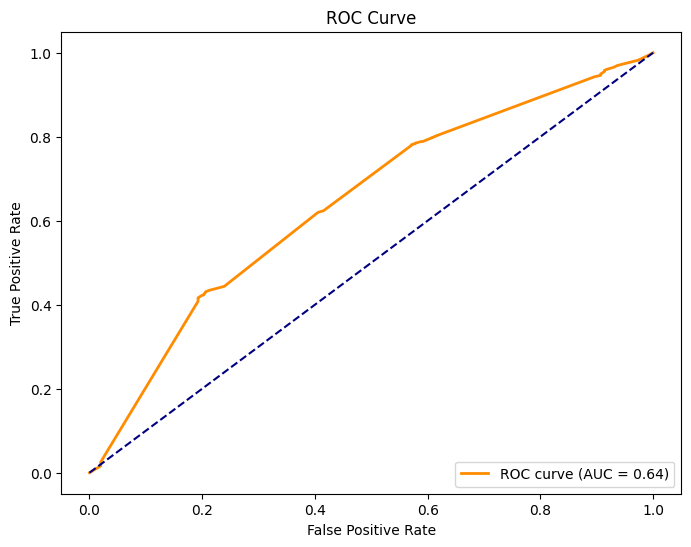

In [22]:
# class_weight = 'balanced'

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title', 'admission_type', 'insurance', 'gender', 'anchor_age', 'seq_num'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v1, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# 

# **질병변수+기본변수 사용**

## XGBoost    

#### scale_pos_weight 사용
모델 정확도: 0.9262
<br>ROC-AUC: 0.6698
<br>F1 Score: 0.9616

데이터 v2, XGBoost 모델 정확도: 0.9262
ROC-AUC: 0.6698
F1 Score: 0.9616


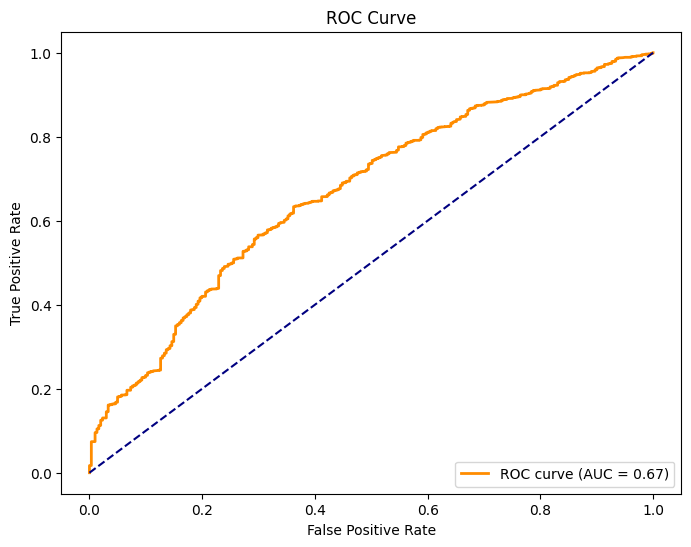

In [19]:
# scale_pos_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale_pos_weight 설정
scale_pos_weight = len(y_train) / sum(y_train)  # Negative to positive class ratio

# XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)


# 예측 및 성능 지표 계산
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, XGBoost 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

####

## Logistic Regression

#### class_weight='balanced' 사용
모델 정확도: 0.6499
<br> ROC-AUC: 0.7052
<br> F1 Score: 0.7745

Regression Equation: y = -0.7422 + (0.1163) * admission_type + (0.1683) * insurance + (-0.1233) * gender + (0.0081) * anchor_age + (0.0925) * seq_num + (0.0828) * infectious_disease + (-0.3676) * renal_system + (-0.7113) * circulatory_system + (0.2281) * hematologic_lymphatic + (-0.7134) * respiratory_system + (-0.1460) * coagulation + (0.1365) * immune_system
R^2 (Determination Coefficient): -2.3614


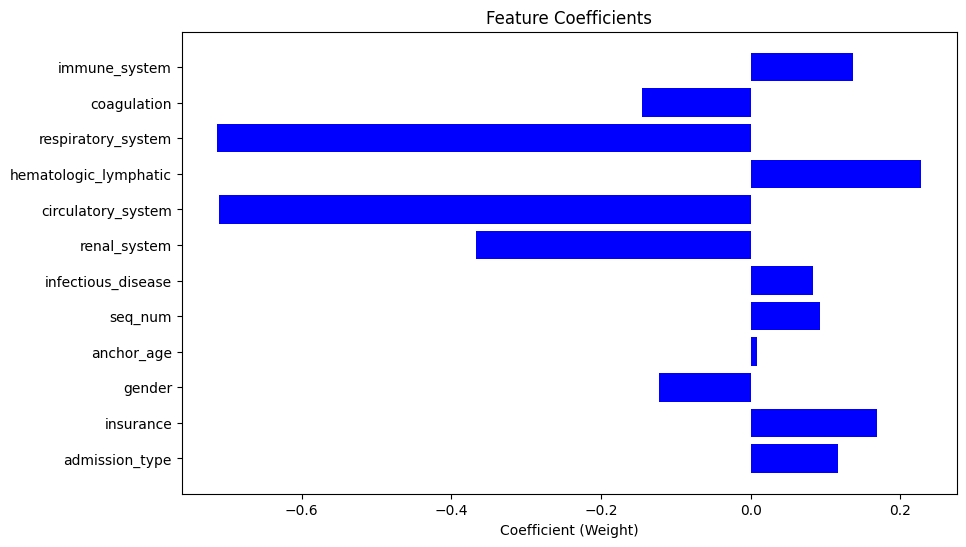

데이터 v2, logistic regression 모델 정확도: 0.6499
ROC-AUC: 0.7052
F1 Score: 0.7745


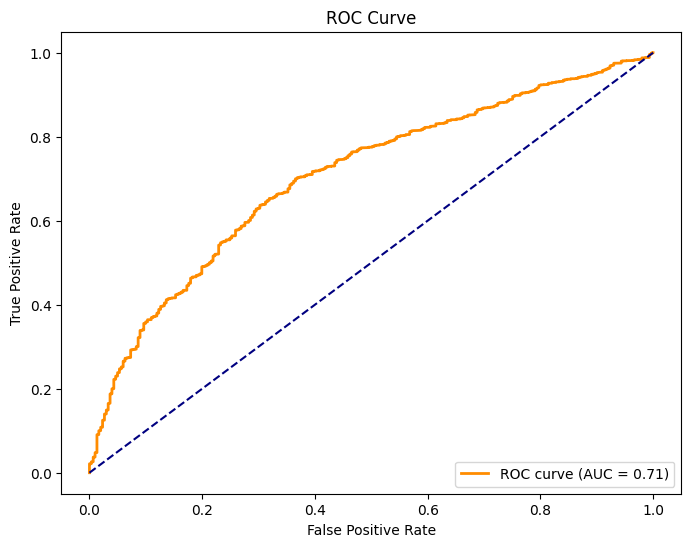

In [6]:
# class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 로지스틱 회귀 모델 학습
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train, y_train)

# 회귀 계수 및 절편
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 회귀식 출력
print(f"Regression Equation: y = {intercept:.4f} + " + " + ".join([f"({coef:.4f}) * {col}" for coef, col in zip(coefficients, X.columns)]))

# R² 계산
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]  # 확률값
r_squared = r2_score(y_test, y_pred_prob)
print(f"R^2 (Determination Coefficient): {r_squared:.4f}")

# 회귀 계수 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, coefficients, color='b')
plt.xlabel('Coefficient (Weight)')
plt.title('Feature Coefficients')
plt.show()

y_pred = logistic_model.predict(X_test)


# 정확도
accuracy_l = accuracy_score(y_test, y_pred)
print(f"데이터 v2, logistic regression 모델 정확도: {accuracy_l:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_l = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc_l:.4f}")

# F1 Score
f1_l = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_l:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_l:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


####

## Random Forest

#### class_weight 사용
모델 정확도: 0.8772
<br>ROC-AUC: 0.6221
<br>F1 Score: 0.9339

데이터 v2, Random Forest 모델 정확도: 0.8772
ROC-AUC: 0.6221
F1 Score: 0.9339


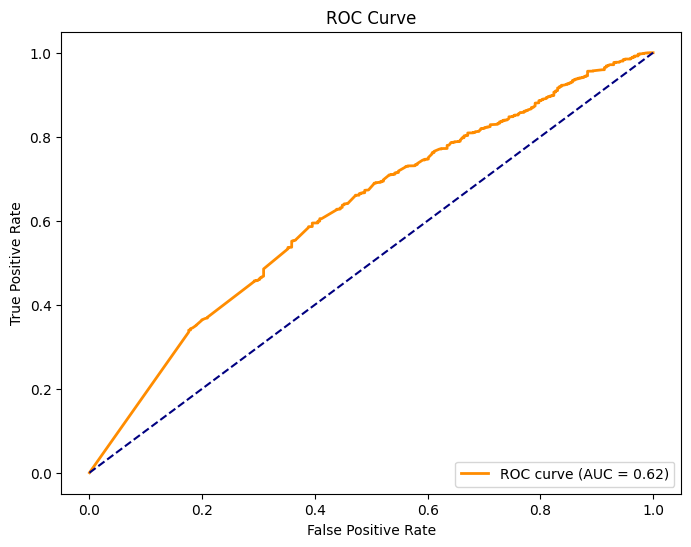

In [27]:
# class_weight

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

# CSV 파일 읽기
enteral_infusion_data = pd.read_csv("./data/enteral_data_final.csv")

# 레이블 및 독립변수 설정
X = enteral_infusion_data.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime', 'time_to_next_admission', 'readmission_within_30_days', 'icd_code', 'long_title'])
y = enteral_infusion_data['readmission_within_30_days']

# 데이터 타입 확인 및 문자열 데이터 변환
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


# 예측 및 성능 지표 계산
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"데이터 v2, Random Forest 모델 정확도: {accuracy:.4f}")

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
